In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance

from hnmchallenge.constant import *
from hnmchallenge.data_reader import DataReader
from hnmchallenge.dataset import Dataset
from hnmchallenge.evaluation.python_evaluation import map_at_k, recall_at_k
from hnmchallenge.feature_manager import FeatureManager
from hnmchallenge.filtered_dataset import FilterdDataset
from hnmchallenge.models.ease.ease import EASE
from hnmchallenge.models.itemknn.itemknn import ItemKNN
from hnmchallenge.models.sgmc.sgmc import SGMC
from hnmchallenge.models.top_pop import TopPop
from hnmchallenge.stratified_dataset import StratifiedDataset

/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
dataset = StratifiedDataset()
dr = DataReader()

In [3]:
base_load_path = dr.get_preprocessed_data_path() / "xgb_models"

In [4]:
VERSION = 0
DATASET = f"dataset_v16_{VERSION}.feather"
MODEL_NAME = f"xgb_{DATASET}.json"

In [5]:
model = xgb.XGBRanker()
model.load_model(base_load_path/MODEL_NAME)

In [6]:
from xgboost import plot_importance

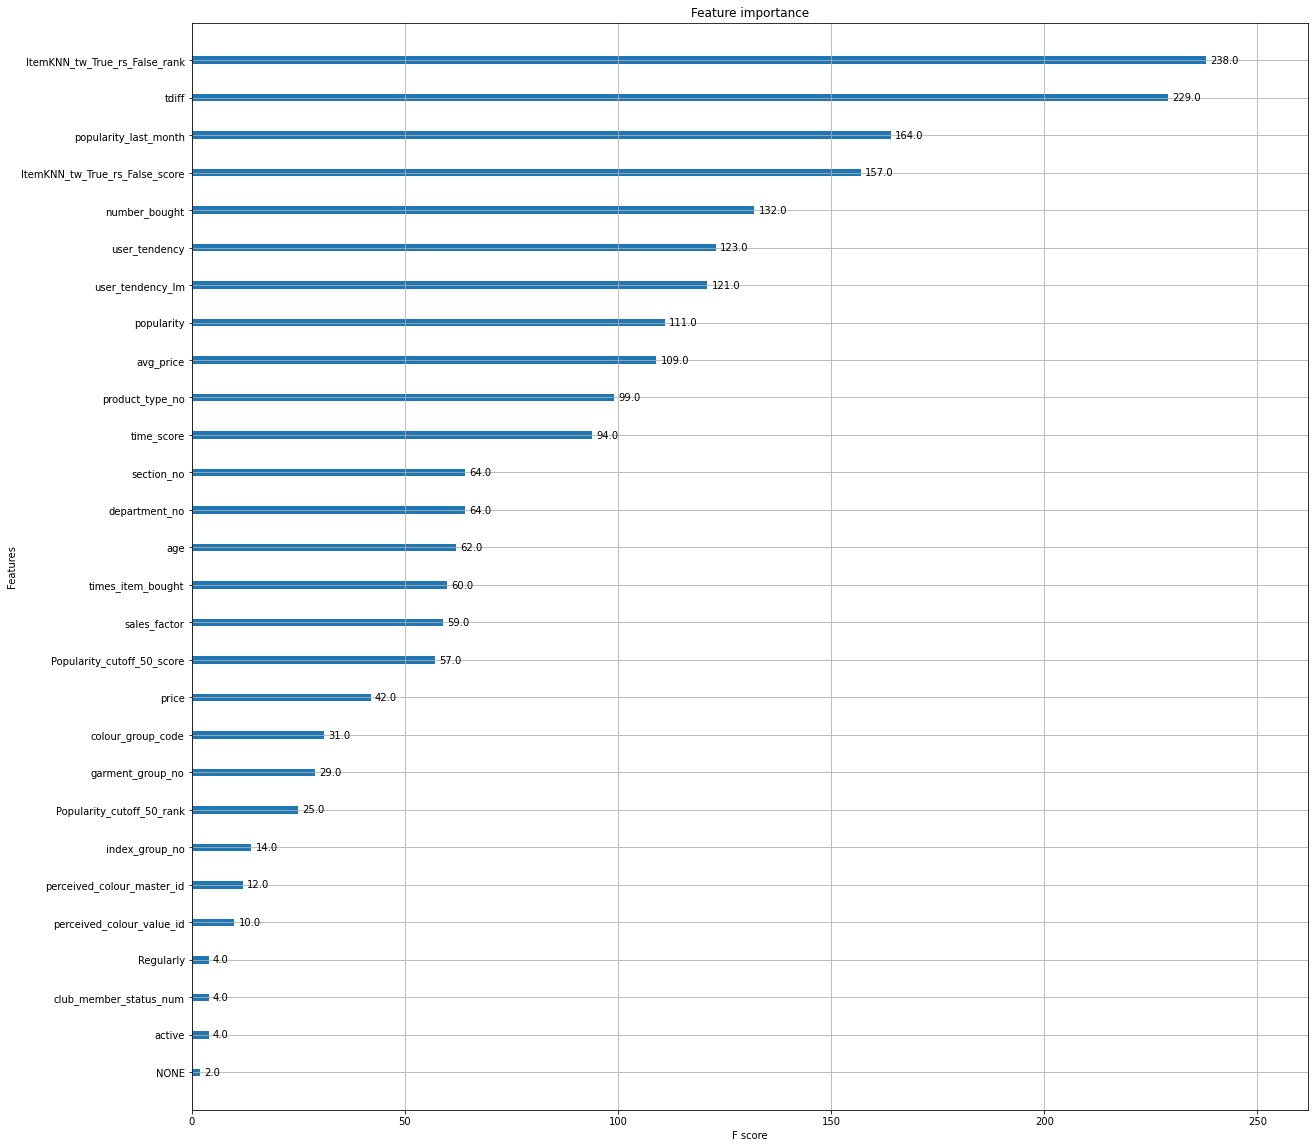

In [7]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(model, ax=ax)
plt.show()

In [8]:
model.best_ntree_limit

61

In [9]:
features = pd.read_feather(dr.get_preprocessed_data_path()/ f"dataset_dfs/full/{DATASET}")

# Remember to use the bert_ntree_limit when taking the predictions

In [10]:
features.head()

,customer_id,ItemKNN_tw_True_rs_False_score,ItemKNN_tw_True_rs_False_rank,Popularity_cutoff_50_score,Popularity_cutoff_50_rank,article_id,colour_group_code,department_no,garment_group_no,index_group_no,...,Monthly,NONE,None,Regularly,avg_price,user_tendency,user_tendency_lm,time_score,tdiff,times_item_bought
0,0,0.010266,1.0,NaN,NaN,1482.0,71,1747,1009,2,...,0,1,0,0,0.027085,0.214286,NaN,1.0,0.006211,1.0
1,0,0.001073,94.0,NaN,NaN,315.0,9,1723,1025,1,...,0,1,0,0,0.027085,0.214286,NaN,NaN,NaN,NaN
2,0,0.001072,95.0,NaN,NaN,414.0,71,1747,1009,2,...,0,1,0,0,0.027085,0.214286,NaN,NaN,NaN,NaN
3,0,0.001061,96.0,NaN,NaN,1542.0,73,1772,1016,2,...,0,1,0,0,0.027085,0.214286,NaN,NaN,NaN,NaN
4,0,0.001060,97.0,NaN,NaN,246.0,9,1338,1017,1,...,0,1,0,0,0.027085,0.214286,NaN,NaN,NaN,NaN


In [11]:
customer_article_df = features[[DEFAULT_USER_COL, DEFAULT_ITEM_COL]].copy()
X = features.drop([DEFAULT_USER_COL, DEFAULT_ITEM_COL], axis=1)

In [12]:
X.head()

,ItemKNN_tw_True_rs_False_score,ItemKNN_tw_True_rs_False_rank,Popularity_cutoff_50_score,Popularity_cutoff_50_rank,colour_group_code,department_no,garment_group_no,index_group_no,popularity,popularity_last_month,...,Monthly,NONE,None,Regularly,avg_price,user_tendency,user_tendency_lm,time_score,tdiff,times_item_bought
0,0.010266,1.0,NaN,NaN,71,1747,1009,2,9558.0,93.0,...,0,1,0,0,0.027085,0.214286,NaN,1.0,0.006211,1.0
1,0.001073,94.0,NaN,NaN,9,1723,1025,1,1372.0,NaN,...,0,1,0,0,0.027085,0.214286,NaN,NaN,NaN,NaN
2,0.001072,95.0,NaN,NaN,71,1747,1009,2,399.0,NaN,...,0,1,0,0,0.027085,0.214286,NaN,NaN,NaN,NaN
3,0.001061,96.0,NaN,NaN,73,1772,1016,2,1992.0,1.0,...,0,1,0,0,0.027085,0.214286,NaN,NaN,NaN,NaN
4,0.001060,97.0,NaN,NaN,9,1338,1017,1,1779.0,NaN,...,0,1,0,0,0.027085,0.214286,NaN,NaN,NaN,NaN


In [13]:
y_pred = model.predict(X, ntree_limit=model.best_ntree_limit)

/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [14]:
customer_article_df["predicted_score"] = y_pred

In [15]:
customer_article_df

,customer_id,article_id,predicted_score
0,0,1482.0,2.056226
1,0,315.0,-3.069991
2,0,414.0,-3.054528
3,0,1542.0,-1.480968
4,0,246.0,-2.678959
...,...,...,...
177995643,1371979,16854.0,-0.200879
177995644,1371979,17047.0,-0.313860
177995645,1371979,17310.0,0.712139
177995646,1371979,6976.0,0.007386


In [16]:
sorted_scores = customer_article_df.sort_values([DEFAULT_USER_COL, "predicted_score"], ascending=[True, False])

In [17]:
sorted_scores

,customer_id,article_id,predicted_score
0,0,1482.0,2.056226
134,0,1797.0,1.941110
135,0,1638.0,1.911652
137,0,4861.0,1.827663
78,0,171.0,1.368098
...,...,...,...
177995619,1371979,17450.0,-0.313860
177995644,1371979,17047.0,-0.313860
177995627,1371979,338.0,-0.340245
177995629,1371979,1719.0,-0.387787


In [18]:
sorted_scores_index = sorted_scores.reset_index(drop=True)

In [19]:
cutoff = sorted_scores_index.groupby(DEFAULT_USER_COL).size().values
i=0 
filter_indices = []
for cut in cutoff:
    filter_indices.extend(range(i, i+12))
    i=i+cut

In [20]:
cutoff.mean()

129.73632851790842

In [21]:
final_df = sorted_scores_index.loc[filter_indices]

In [22]:
final_df

,customer_id,article_id,predicted_score
0,0,1482.0,2.056226
1,0,1797.0,1.941110
2,0,1638.0,1.911652
3,0,4861.0,1.827663
4,0,171.0,1.368098
...,...,...,...
177995605,1371979,19797.0,0.551550
177995606,1371979,19403.0,0.548932
177995607,1371979,171.0,0.546076
177995608,1371979,3468.0,0.520987


In [23]:
final_final_df = final_df.drop("predicted_score", axis=1)

In [24]:
from hnmchallenge.submission_handler import SubmissionHandler
sh = SubmissionHandler()                                               

In [25]:
sh.create_submission_filtered_data_full_users([final_final_df], sub_name="xgb_16")